# library required

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import pickle

In [17]:
import pandas as pd
import datetime
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS


import nltk
from nltk.stem.porter import *
nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
from nltk.stem import WordNetLemmatizer, SnowballStemmer

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/niloofar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Explatory Analysis

In [311]:
df=pd.read_csv("/Users/niloofar/Downloads/Hotel_Reviews.csv")

# total number of hotels:

len(set(df.Hotel_Name))
df.Hotel_Name.value_counts()

#change the format of time to datetime

df['Review_Date']=pd.to_datetime(df['Review_Date'], format='%m/%d/%Y')

In [312]:
#Selecting one sample hotel with highest number of review
df1=df[df.Hotel_Name=="Britannia International Hotel Canary Wharf"]

df1.index = range(df1.shape[0])

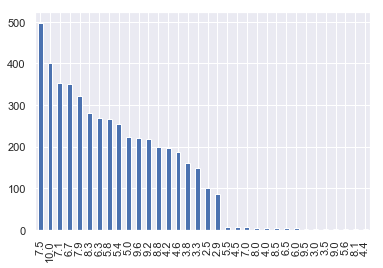

In [313]:
df1['Reviewer_Score'].value_counts().plot(kind='bar')

# Data pre-processing for textual variables

In [314]:
import pandas as pd
data_text = pd.DataFrame(df1['Positive_Review'])
data_text['Neg'] = df1['Negative_Review']
data_text['index'] = data_text.index
data_text.columns=['pos','neg','index']
data_text['pos']=["  " if x == 'No Positive' else x for x in data_text['pos']]
data_text['neg']=["  " if x == 'No Negative' else x for x in data_text['neg']]
# data_text['review']=data_text['pos']+data_text['neg']
# df=data_text['review']

In [315]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


In [316]:
docp=list(sent_to_words(data_text['pos']))
docn=list(sent_to_words(data_text['neg']))


In [317]:
Time_Table=df1[['Review_Date','Reviewer_Score']]

In [19]:
Time_Table.head()

,Review_Date,Reviewer_Score
0,2017-08-03,7.9
1,2017-08-03,8.3
2,2017-08-02,6.3
3,2017-08-02,5.4
4,2017-08-02,6.3


In [318]:
pre_docn=list(data_text['neg'])
pre_docp=list(data_text['pos'])

# Functions

In [10]:
# stop_list = ["Nothing","ok","good","great","excellent","very","london","nice","lovely","okay","like","wharf","canary","room","amaze",   
#              'Indian','Italian','hotel','room','nothing','great','excellent','good','ideal','one','people','pleasant','wa']
stop_words=['hotel','room','nothing','would','could','want','go','recommend','everything','be','was','good','ok','great','poor']            

In [11]:
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import English, STOP_WORDS
# from en_core_web_lg import *
# import en_core_web_lg

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import pickle

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import ast

In [3]:
def process(input_data, no_list,time_table,start, limit, step,file_name,verbose):
    
    #'''data pre processing using spacy '''
    nlp = English()
    lp= spacy.load("en")
    nlp.Defaults.stop_words.update(stop_words)

    for word in STOP_WORDS:
        lexeme = nlp.vocab[word]
        lexeme.is_stop = True

    flatten = lambda l: [item for sublist in l for item in sublist]

    def spacy_root(text):
        nlp = spacy.load("en_core_web_sm")
        doc=[]
        l=[]
        for word in text:
            ss=nlp(word)
            for chunk in ss.noun_chunks:
                l.append(chunk.root.text)
        doc.append(l)
        return(doc)


    def lemmatizer(doc):
        # This takes in a doc of tokens from the NER and lemmatizes them. 
        # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
        doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
        doc = u' '.join(doc)
        return nlp.make_doc(doc)

    def remove_stopwords(doc):
        spacy_nlp = spacy.load('en_core_web_sm')
        spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

        for i in no_list:  
            STOP_WORDS.add(i)

        for word in STOP_WORDS:
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True

        tokens = [token.text for token in doc if not token.is_stop and token.is_punct != True and  len(token) >=3]
        tokens=[i.lower() for i in tokens]
        return tokens
    nlp.add_pipe(lemmatizer,name='lemmatizer')
    nlp.add_pipe(remove_stopwords, name="stopwords", last=True)
    nlp.add_pipe(spacy_root,name='root')

    def compute_coherence_values(dictionary, corpus, texts, limit, start, step):

        coherence_values = []
        model_list = []
        for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
            model =gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=num_topics,
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())

        return model_list, coherence_values
    
    
     #build a topic model
    
    def format_topics_sentences(ldamodel, corpus, texts):
    
        sent_topics_df = pd.DataFrame()

        # Get main topic in each document
        for i, row_list in enumerate(ldamodel[corpus]):
            row = row_list[0] if ldamodel.per_word_topics else row_list            
            # print(row)
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            
            # Get the Dominant topic, Perc Contribution and Keywords for each document
            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:  # => dominant topic
                    wp = ldamodel.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                else:
                    break
        sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

        # Add original text to the end of the output
        contents = pd.Series(texts)
        sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
        return(sent_topics_df)

    if verbose==True:
            
    
        doc_list = []
        for doc in tqdm(input_data):
            pr = nlp(doc)
            doc_list.append(pr)
            
        dd=[flatten(i) for i in doc_list]
        
        with open(file_name, 'wb') as f:
            pickle.dump(dd, f)
        
        
    else:    
        
        with open(file_name, 'rb') as f:
            dd = pickle.load(f)

       
    
        
    words = corpora.Dictionary(dd)
    corpus = [words.doc2bow(doc) for doc in dd]
    

    model_list, coherence_values = compute_coherence_values(dictionary=words, corpus=corpus, texts=dd, start=start, limit=limit, step=step)
    opt=coherence_values.index(max(coherence_values))
    optimal_model=model_list[opt]

    df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=input_data)

    # Format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    df_dominant_topic=df_dominant_topic.merge(time_table, left_index=True, right_index=True)

    return(df_dominant_topic)





In [39]:

positive_topic=process(input_data=pre_docp, no_list=stop_words,time_table=Time_Table,start=3, limit=20, step=1,file_name="doc_pos",verbose=True)


In [49]:
# with open("/Users/niloofar/Documents/insight/data/cleaned/hotel1/positive", 'wb') as f:
#             pickle.dump(positive_topic, f)

In [50]:
negative_topic=process(input_data=pre_docn, no_list=stop_words,time_table=Time_Table,start=3, limit=20, step=1,file_name="doc_neg",verbose=True)

In [53]:
# with open("/Users/niloofar/Documents/insight/data/cleaned/hotel1/negative", 'wb') as f:
#             pickle.dump(negative_topic, f)

In [304]:
topic_pos=pd.DataFrame({"Dominant_Topic": [0,1,2,3,4,5,6,7,8],
                    "Topic_Name":["Decoration","facility","location",
                                  "price","amenities","parking","general","staff_receptionist","Room_size"]})
                 



In [305]:
topic_neg=pd.DataFrame({"Dominant_Topic": [0,1,2,3,4,5,6,7],
                    "Topic_Name":["general","service_food","air_conditioning",
                                  "staff_receptionist","Decoration","bed/bath/shower","wifi","parking"]})
                 


In [23]:
def table_modify (table,topic_table):
    table=table.merge(topic_table, on=['Dominant_Topic'])
#     table.loc[table.Topic_Perc_Contrib<0.3 ,'Topic_Name']='None'
    return(table[['Document_No','Review_Date','Reviewer_Score','Topic_Name']])

In [307]:
with open("/Users/niloofar/Documents/insight/data/cleaned/hotel1/negative",'rb') as f:
        negative=pickle.load(f,encoding='latin1')
        
with open("/Users/niloofar/Documents/insight/data/cleaned/hotel1/positive",'rb') as f:
        positive=pickle.load(f,encoding='latin1')

In [319]:
negative_topic=process(input_data=pre_docn, no_list=stop_words,time_table=Time_Table,start=3, limit=20, step=1,file_name="doc_neg",verbose=False)
positive_topic=process(input_data=pre_docp, no_list=stop_words,time_table=Time_Table,start=3, limit=20, step=1,file_name="doc_pos",verbose=False)

In [321]:
pos_topic_final=table_modify(positive_topic,topic_pos)
neg_topic_final=table_modify(negative_topic,topic_neg)

In [322]:
neg_topic_final.head()

,Document_No,Review_Date,Reviewer_Score,Topic_Name
0,0,2017-08-03,7.9,None
1,3,2017-08-02,5.4,bed/bath/shower
2,7,2017-08-02,5.4,bed/bath/shower
3,9,2017-08-02,7.5,bed/bath/shower
4,10,2017-08-02,8.8,bed/bath/shower


In [24]:
def table_process(table_topic,input_data):
    
    
    def sentiment_analyzer_scores(sentence):
        analyser = SentimentIntensityAnalyzer()
        score = analyser.polarity_scores(sentence)
        return("{}".format(str(score)))
   
    sentiment_eval=[sentiment_analyzer_scores(i) for i in input_data]
    sent_score=[ast.literal_eval(i) for i in  sentiment_eval]
    sent_table=pd.DataFrame(sent_score)
    sent_table=['Document_No']=sent_table=.index
    sent_table==sent_table=[['compound','Document_No']]
    table_sentiment=table_topic.merge(sent_table=, on=['Document_No'])
    table_sentiment.loc[table_sentiment.Topic_Name=="None" ,'compound']=0
    return(table_sentiment)
    
#     return(table2.pivot(index='Document_No',columns='Topic_Name',values='neg'))
    

In [323]:
pos_sentiment=table_process(pos_topic_final,pre_docp)
neg_sentiment=table_process(neg_topic_final,pre_docn)

In [324]:
Tp=pos_sentiment[['Document_No','Topic_Name','compound']]
Tn=neg_sentiment[['Document_No','Topic_Name','compound']]

In [325]:
Tp1=Tp.pivot(index='Document_No',columns='Topic_Name',values='compound')
Tn1=Tn.pivot(index='Document_No',columns='Topic_Name',values='compound')

In [326]:
Tp1=Tp1.drop(['None'],axis=1)
Tn1=Tn1.drop(['None'],axis=1)

In [327]:
Tp1.shape[0]

4789

In [328]:
common_columns=list(set(Tp1.columns).intersection(Tn1.columns))
common_columns.append('Document_No')
# common_columns.remove('None')

In [329]:
Tp1=Tn1.merge(Tp1,on=common_columns)

In [330]:
# Tp1=Tp1.drop(['None'],axis=1)
Tp1=Tp1.fillna(0)
Tp1=Tp1.merge(neg_topic_final[['Document_No','Review_Date','Reviewer_Score']],on=['Document_No'])
# Tp1


In [331]:
zero_col=['general','Decoration','parking','staff_receptionist']
Tp1['sum']=Tp1['air_conditioning']+Tp1['bed/bath/shower']+Tp1['service_food']+Tp1['wifi']+Tp1['Room_size']+Tp1['amenities']+Tp1['facility']+Tp1['location']+Tp1['price']
Tp1=Tp1[Tp1['sum']!=0]

In [332]:
with open("/Users/niloofar/Documents/insight/data/cleaned/hotel1/Final_res", 'wb') as f:
            pickle.dump(Tp1, f)

In [333]:
with open("/Users/niloofar/Documents/insight/data/cleaned/hotel1/Final_res",'rb') as f:
        df=pickle.load(f,encoding='latin1')

In [446]:
# xx=Tp1[['Decoration','Review_Date']]
min(Tp1.Review_Date)

Timestamp('2015-08-04 00:00:00')

In [455]:
Tp1.head()

,Document_No,air_conditioning,bed/bath/shower,service_food,wifi,Room_size,amenities,facility,location,price,Review_Date,Reviewer_Score,sum
0,0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.5719,2017-08-03,7.9,0.5719
3,3,0.0,-0.9578,0.0,0.0000,0.0,0.0,0.0,0.0,0.4466,2017-08-02,5.4,-0.5112
4,4,0.0,0.0000,0.0,0.4939,0.0,0.0,0.0,0.0,0.8843,2017-08-02,6.3,1.3782
6,7,0.0,-0.2006,0.0,0.0000,0.0,0.0,0.0,0.0,0.7269,2017-08-02,5.4,0.5263
7,9,0.0,0.2263,0.0,0.0000,0.0,0.0,0.0,0.0,0.8860,2017-08-02,7.5,1.1123


In [334]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

df=Tp1[(Tp1['Review_Date']>='2017-06-03') & (Tp1['Review_Date']<='2017-07-03')]

colnames=['Document_No','sum','Review_Date']
df=df.drop(colnames,axis=True)
x_column=[i  for i in df.columns if i!="Reviewer_Score"]

x_column
# import numpy as np
# import matplotlib.pyplot as plt

# from sklearn.datasets import make_classification
# from sklearn.ensemble import ExtraTreesClassifier

# # # Build a classification task using 3 informative features

# # # Build a forest and compute the feature importances

# X, y = make_classification(n_samples=df.shape[0],
#                            n_features=10,
#                            n_informative=3,
#                            n_redundant=0,
#                            n_repeated=0,
#                            n_classes=2,
#                            random_state=0,
#                            shuffle=False)

# forest = ExtraTreesClassifier(n_estimators=250,
#                               random_state=0)

# forest.fit(X, y)
# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_],
#              axis=0)
# indices = np.argsort(importances)[::-1]

# # Print the feature ranking
# print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# # Plot the feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(X.shape[1]), importances[indices],
#        color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
# plt.show()

['Decoration',
 'air_conditioning',
 'bed/bath/shower',
 'general',
 'parking',
 'service_food',
 'staff_receptionist',
 'wifi',
 'Room_size',
 'amenities',
 'facility',
 'location',
 'price']

In [335]:
from sklearn.model_selection import train_test_split

y = df.Reviewer_Score
X = pd.DataFrame(df, columns = x_column)
np.random.seed(seed = 42)
# X['random'] = np.random.random(size = len(X))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.8, random_state = 42)

In [336]:
from sklearn.metrics import r2_score,mean_squared_error
from rfpimp import permutation_importances
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)

rf.fit(X_train, y_train)

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

model=permutation_importances(rf, X_train, y_train, r2)

In [465]:
# reg=RidgeCV(alphas=np.arange(0.05,3.01,0.05),scoring="neg_mena_square_error",cv=None).fit(X_train,y_train)
# ridgeReg=Ridge(alpha=reg.alpha)
# scores=cross_val_score(ridgeReg,X_train,y_train,cv=X_train.shape[0])

In [461]:
# from sklearn.linear_model import RidgeCV,Ridge
# ridgeReg.fit(X_train,y_train)
# index=np.argsort(-ridgeReg.coef_)
# ordered=[features[i] for i in index]
# dataBar=[go.Bar(x=ordered,y=ridgeReg.coef_[index])]
# plotly.offline.iplot(dataBar,filename="test")

In [295]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   mode = 'regression',
                                                   feature_names = X_train.columns,
                                                   categorical_features = [8], 
                                                   categorical_names = ['CHAS'], 
                                                   discretize_continuous = True)
                                                   
np.random.seed(42)
exp = explainer.explain_instance(X_valid.values[120], rf.predict, num_features = len(x_column))
exp.show_in_notebook(show_all=False) #only the features used in the explanation are displayed

exp = explainer.explain_instance(X_valid.values[12], rf.predict, num_features = len(x_column))
exp.show_in_notebook(show_all=True)

NameError: name 'X_train' is not defined

In [428]:
from sklearn.base import clone 

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

In [430]:
model

,Importance
Feature,
price,2.010855e+00
amenities,1.420334e-01
service_food,8.275019e-02
wifi,6.387951e-02
Room_size,2.117421e-03
air_conditioning,-1.110223e-16
facility,-1.110223e-16
location,-1.110223e-16
bed/bath/shower,-5.916121e-04


In [57]:
# drop_col_feat_imp(model, X_train, y_train, random_state = 42)

In [384]:
ss=df.groupby('Review_Date').agg({'bed/bath/shower':['mean']})

ss=pd.DataFrame(ss)

In [311]:
from __future__ import print_function
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular


In [312]:
predic_fn_rf=lambda x: model.rf.predict_proba(x).astype('float')

In [235]:
negative_topic.loc[25,'Text']

' Staff Those of you with poker faces you should smile more you should ask a guest whether is in a need of help with luggage not just whether he she wants to pay in advance for breakfast or open an account with you or whether would prefer a more expensive room Also saying good morning and good evening to your guests once in a while is good manners Looking like a gentleman won t make you one after all it s not everything in life about money Wifi Rooms with windows at an extra charge of 20 pounds day Taxi companies you co operate with that instead of 5 mins they turn up in 35 It s not your fault entirely but most definitely not your guests '

In [155]:
positive_topic[['Dominant_Topic','Keywords']].drop_duplicates()

,Dominant_Topic,Keywords
0,3.0,"location, staff, value, breakfast, money, love..."
5,7.0,"service, book, time, business, fault, bite, co..."
6,8.0,"size, night, space, cost, minute, day, bath, f..."
11,2.0,"view, office, window, river, date, rooms, bedr..."
14,6.0,"wharf, food, place, lot, deal, plenty, meeting..."
26,1.0,"price, bed, position, arrival, house, ease, re..."
62,0.0,"facility, restaurant, bathroom, floor, cleanli..."
69,5.0,"bar, area, tube, station, park, distance, atmo..."
94,4.0,"reception, style, furniture, stuff, coffee, re..."


In [153]:
neg_topic_final.head()

,Document_No,Review_Date,Reviewer_Score,Topic_Name
0,0,2017-08-03,7.9,None
1,3,2017-08-02,5.4,bed/bath/shower
2,7,2017-08-02,5.4,bed/bath/shower
3,9,2017-08-02,7.5,bed/bath/shower
4,10,2017-08-02,8.8,bed/bath/shower


In [137]:
aa=[sentiment_analyzer_scores(i) for i in pre_docn]
aa
sent_score=[ast.literal_eval(i) for i in aa]
SC=pd.DataFrame(sent_score)

In [148]:
table1=neg_topic_final[['Document_No','Topic_Name']]
table2=table1.merge(SC, on=['Document_No'])


In [146]:
neg_topic.loc[4784]

Document_No                                                        2579
Dominant_Topic                                                        0
Topic_Perc_Contrib                                               0.2763
Keywords              wasn, rooms, train, fact, age, bag, face, heat...
Text                   Room was very noisy from clanking of steam pipes
Review_Date                                         2017-03-24 00:00:00
Reviewer_Score                                                      6.7
Topic_Name                                                         None
Name: 4784, dtype: object

# Slides preparation

In [467]:
# positive_topic=process(input_data=pre_docp, no_list=stop_words,time_table=Time_Table,start=2, limit=10, step=1,file_name="doc_pos",verbose=False)

with open('doc_pos', 'rb') as f:
            dd = pickle.load(f)
        

In [468]:
words = corpora.Dictionary(dd)
corpus = [words.doc2bow(doc) for doc in dd]

In [474]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model =gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [475]:
model_list, coherence_values = compute_coherence_values(dictionary=words, corpus=corpus, texts=dd, start=3, limit=15, step=1)
opt=coherence_values.index(max(coherence_values))
optimal_model=model_list[opt]


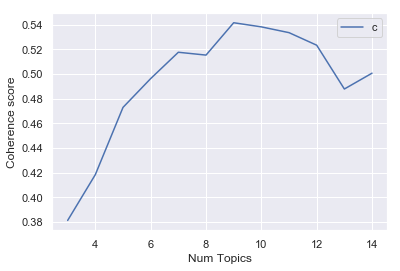

In [476]:
limit=15; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [478]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.213*"service" + 0.067*"cleanliness" + 0.061*"proximity" + 0.059*"decor" + '
  '0.046*"thing" + 0.038*"position" + 0.035*"centre" + 0.033*"shower" + '
  '0.030*"transport" + 0.026*"concierge"'),
 (1,
  '0.276*"price" + 0.255*"bed" + 0.088*"tube" + 0.076*"station" + 0.029*"date" '
  '+ 0.024*"distance" + 0.013*"house" + 0.010*"requirement" + 0.008*"sleep" + '
  '0.006*"mattress"'),
 (2,
  '0.129*"office" + 0.077*"river" + 0.064*"bedroom" + 0.062*"convenience" + '
  '0.047*"train" + 0.034*"thames" + 0.029*"shop" + 0.019*"charge" + '
  '0.018*"overlook" + 0.018*"building"'),
 (3,
  '0.395*"view" + 0.050*"window" + 0.042*"book" + 0.040*"night" + 0.039*"city" '
  '+ 0.032*"work" + 0.028*"rooms" + 0.019*"bite" + 0.018*"bath" + '
  '0.014*"fact"'),
 (4,
  '0.159*"place" + 0.107*"bathroom" + 0.090*"reception" + 0.061*"space" + '
  '0.047*"style" + 0.031*"plenty" + 0.026*"atmosphere" + 0.025*"fashion" + '
  '0.024*"entrance" + 0.018*"purpose"'),
 (5,
  '0.308*"value" + 0.201*"money" + 

In [479]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, words)
vis

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.426581  0.101542       1        1  20.560743
8     -0.060329 -0.405359       2        1  15.515198
7      0.040753  0.038696       3        1  13.809059
3      0.044680  0.041182       4        1  13.778409
1      0.026969  0.031331       5        1  10.760990
5      0.038207  0.034095       6        1   6.879221
4      0.081008  0.041262       7        1   6.552076
0      0.077526  0.041145       8        1   6.197772
2      0.088221  0.038632       9        1   3.367772
6      0.089546  0.037475      10        1   2.578752, topic_info=     Category         Freq         Term        Total  loglift  logprob
0     Default  1674.000000     location  1674.000000  30.0000  30.0000
11    Default  1037.000000        staff  1037.000000  29.0000  29.0000
84    Default   624.000000         view   624.000000  28.0000  28.0000
22    Default   342.000000        price   342.000000  27.0000  27.0000
4     Default   316.000000          bed   316.000000  26.0000  26.0000
50    Default   244.000000        value   244.000000  25.0000  25.0000
15    Default   304.000000    breakfast   304.000000  24.0000  24.0000
44    Default   160.000000        money   160.000000  23.0000  23.0000
155   Default   152.000000      service   152.000000  22.0000  22.0000
161   Default   181.000000         food   181.000000  21.0000  21.0000
174   Default   128.000000         size   128.000000  20.0000  20.0000
51    Default   221.000000        wharf   221.000000  19.0000  19.0000
58    Default   120.000000        place   120.000000  18.0000  18.0000
24    Default   157.000000   restaurant   157.000000  17.0000  17.0000
172   Default   152.000000          bar   152.000000  16.0000  16.0000
106   Default   147.000000         area   147.000000  15.0000  15.0000
32    Default   110.000000         tube   110.000000  14.0000  14.0000
94    Default    81.000000     bathroom    81.000000  13.0000  13.0000
99    Default   121.000000     facility   121.000000  12.0000  12.0000
30    Default    94.000000      station    94.000000  11.0000  11.0000
131   Default    69.000000    reception    69.000000  10.0000  10.0000
459   Default    51.000000       office    51.000000   9.0000   9.0000
81    Default    41.000000         park    41.000000   8.0000   8.0000
55    Default    80.000000       window    80.000000   7.0000   7.0000
128   Default    49.000000  cleanliness    49.000000   6.0000   6.0000
122   Default    47.000000        space    47.000000   5.0000   5.0000
53    Default    67.000000         book    67.000000   4.0000   4.0000
285   Default    44.000000    proximity    44.000000   3.0000   3.0000
35    Default    70.000000         love    70.000000   2.0000   2.0000
85    Default    64.000000        night    64.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
64    Topic10    18.278376         deal    19.642559   3.5859  -2.7839
72    Topic10    12.082880          way    13.447342   3.5509  -3.1978
80    Topic10    11.956238          car    13.320264   3.5498  -3.2084
71    Topic10     9.686094       travel    11.050380   3.5261  -3.4189
66    Topic10     9.126774          doe    10.491499   3.5185  -3.4784
247   Topic10     8.859577         desk    10.223606   3.5147  -3.5081
1157  Topic10     6.163878     ambiance     7.861529   3.4146  -3.8709
440   Topic10     3.957986    selection     5.321991   3.3618  -4.3139
60    Topic10     3.862804          air     5.226819   3.3555  -4.3382
781   Topic10     3.246288     occasion     4.611031   3.3069  -4.5121
608   Topic10     3.963405    direction     5.677920   3.2984  -4.3125
432   Topic10     2.618634       andrea     4.460015   3.1254  -4.7270
952   Topic10     1.661735          leg     3.026460   3.0583  -5.1818
246   Topic10     1.111645    condition     2.475622   2.8572  -5.5838
215   Topic10     0.777368         suit    

# Validation

In [7]:
with open('/Users/niloofar/Documents/insight/data/cleaned/hotel2/trip_ad', 'rb') as f:
            trip_ad= pickle.load(f)



In [8]:
trip_ad.head()
Time_Table=trip_ad[['Date','rating']]
file_name='/Users/niloofar/Documents/insight/data/cleaned/hotel2/doc_pos'

In [13]:

Topic=process(input_data=list(trip_ad['Review']), no_list=stop_words,time_table=Time_Table,start=3, limit=20, step=1,file_name=file_name,verbose=False)



In [43]:
Topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Date,rating
0,0,0.0,0.2695,"location, restaurant, view, staff, downtown, m...","No, seriously, don't stay here. Spend a few m...",January 2020,10
1,1,0.0,0.3239,"location, restaurant, view, staff, downtown, m...",Great central location for our first visit to ...,November 2019,50
2,2,8.0,0.4669,"night, cruise, bathroom, bed, day, elevator, t...",We stayed on a Friday night one week & the nex...,January 2020,30
3,3,8.0,0.2703,"night, cruise, bathroom, bed, day, elevator, t...",From very friendly taxi driver who charged a r...,January 2020,50
4,4,0.0,0.3869,"location, restaurant, view, staff, downtown, m...","If you are looking for a friendly, modern hote...",January 2020,50
5,5,8.0,0.4037,"night, cruise, bathroom, bed, day, elevator, t...",We stayed one night as we had a cruise booked ...,January 2020,20
6,6,8.0,0.3661,"night, cruise, bathroom, bed, day, elevator, t...",The place was super run down and during check ...,January 2020,20
7,7,8.0,0.2958,"night, cruise, bathroom, bed, day, elevator, t...",Valet Parking and check in were a breeze when ...,January 2020,10
8,8,0.0,0.3263,"location, restaurant, view, staff, downtown, m...","Wow talk about close to everything arena,baysi...",January 2020,50
9,9,8.0,0.3483,"night, cruise, bathroom, bed, day, elevator, t...",We enjoyed a one-night stay at the YVE Hotel M...,January 2020,30


In [17]:
Topic["Keywords"][4]

'location, restaurant, view, staff, downtown, miami, street, shop, breakfast, price'

In [44]:
Topic["Text"][2649]

"I have to say, I will never ever stay at this hotel again, nor can I ever recommend this hotel.  Read the previous comments on the hotel, and many people highly recommended this hotel due to the recent renovations.  However, there is a large amount of work they need to complete before allowing guests to stay at this hotel moving forward.  First, elevators--it will take a good 15-20 mins for the elevator to come to your floor, so if you are on the top floor of the hotel, plan on waiting or hoovin' it down the steps.  (By the way, in 90+ degree weather, expect to be drenched in sweat when you hit the lobby).  The room we checked into was a suite, or so they say.  The room was very small and very dirty.  When we checked in, their was still rings on the night stands and coffee table…"

In [32]:
pd.Series(Topic['Dominant_Topic']).value_counts()


8.0    1777
0.0     685
2.0     184
4.0      10
6.0       4
Name: Dominant_Topic, dtype: int64

In [20]:
topic_table=pd.DataFrame({"Dominant_Topic": [8,0,2,4,6],
                    "Topic_Name":["amenities","location","staff",
                                  "extra_charge","parking"]})
 


In [65]:
Topic["Date"]= pd.to_datetime(Topic["Date"])

In [21]:
table=Topic.merge(topic_table, on=['Dominant_Topic'])


In [25]:
sentiment_topic=table_process(table,list(trip_ad['Review']))


In [45]:
sentiment_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Date,rating,Topic_Name,compound
0,0,0.0,0.2695,"location, restaurant, view, staff, downtown, m...","No, seriously, don't stay here. Spend a few m...",January 2020,10,location,-0.4023
1,1,0.0,0.3239,"location, restaurant, view, staff, downtown, m...",Great central location for our first visit to ...,November 2019,50,location,0.9285
2,4,0.0,0.3869,"location, restaurant, view, staff, downtown, m...","If you are looking for a friendly, modern hote...",January 2020,50,location,0.9915
3,8,0.0,0.3263,"location, restaurant, view, staff, downtown, m...","Wow talk about close to everything arena,baysi...",January 2020,50,location,0.8689
4,13,0.0,0.4330,"location, restaurant, view, staff, downtown, m...",Stay here for a stellar experience!! Yve Hote...,August 2019,50,location,0.9963


In [41]:
sentiment_topic["Text"][2653]

'Although the hotel was lovely, the aftermath was horrendous.  First I had to call to get them to refund the money charged against my credit card for expenses.  The call turned into a yelling match with the financial department.  Then, a month later, the charge was run again.  Why do they still have my credit card information and why are they using it. I attempted to contact them but got no response.  Horrible experience.'

In [42]:
sentiment_topic["compound"][2653]

-0.7469

In [214]:
import datetime
from datetime import date, timedelta

sdate = date(2013, 1, 1)   # start date
edate = date(2020, 1, 1)   # end date
delta = edate - sdate
year=(delta/365).days

Date=[]
for i in range(0,year):
    if i==3:
        pt=sdate + timedelta(days=366)
    else:    
        pt=sdate + timedelta(days=365)
    Date.append([sdate,pt])
    sdate=pt

# Date=[i.strftime('%Y-%m-%d') for i in Date]



In [201]:
# [date_obj.strftime('%Y%m%d') for date_obj in mondays]

# flatten = lambda l: [item for sublist in l for item in sublist]
# P=flatten(Date)
# P=[i.strftime('%Y-%m') for i in P]


In [146]:
# import math as m
# K=[]
# for i in range(0, m.ceil(len(P)/2)):
#     a= P[:2]
#     K.append(a)
#     P=P[2:]


In [216]:
K=[Date[i][0].year for i in range(0,len(Date))]

In [282]:
sentiment_topic_final=sentiment_topic.pivot(index='Document_No',columns='Topic_Name',values='compound').fillna(0)
sentiment_topic_final=sentiment_topic_final.merge(sentiment_topic[['Document_No','Date','rating']],on=['Document_No'])
sentiment_topic_final.columns=['Document_No','amenities','extra_charge','location','parking','staff','Review_Date','Reviewer_Score']
col_list=list(topic_table.Topic_Name)
sentiment_topic_final['sum']=sentiment_topic_final[col_list].sum(axis=1)
# with open('sentiment_topic_final', 'wb') as f:
#     pickle.dump('/Users/niloofar/Documents/insight/data/cleaned/hotel2/sentiment_topic_final', f)



In [283]:
# with open('/Users/niloofar/Documents/insight/data/cleaned/hotel2/sentiment_topic_final', 'wb') as f:
#     pickle.dump(sentiment_topic_final, f)



In [276]:
type(sentiment_topic_final.Review_Date)

pandas.core.series.Series

In [277]:
ss=sentiment_topic_final.loc[(sentiment_topic_final.Review_Date>=Date[0][0]) & (sentiment_topic_final.Review_Date<Date[0][1])]
# ss.Review_Date = [i.strftime("%Y-%m-%d") for i in ss.Review_Date]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


In [291]:
bb=set(ss.Time)
nn=sorted([i.strftime("%Y-%m-%d") for i in bb])

In [294]:
nn

['2013-03-01',
 '2013-04-01',
 '2013-05-01',
 '2013-06-01',
 '2013-07-01',
 '2013-08-01',
 '2013-09-01',
 '2013-10-01',
 '2013-11-01',
 '2013-12-01']

In [287]:
ss=pd.DataFrame(ss)
ss.Reviewer_Score=[int(i) for i in ss.Reviewer_Score]
ss=ss.groupby(['Review_Date'])['Reviewer_Score'].mean()
ss=pd.DataFrame(ss)
ss=pd.DataFrame({'Time':ss.index,'Score':ss.Reviewer_Score})
# ss=pf.DataFrame({'Date':ss.index})

In [288]:
ss.columns

Index(['Time', 'Score'], dtype='object')